In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
from omegaconf import OmegaConf
import hydra
import sys
import einops
import math
import seaborn as sns
sys.path.append('../')
import matplotlib.pyplot as plt
import math
from src.datasets import SequenceImageTransitionDataset
from src.patch_vae import PatchVAE
from src.vqvae import VQVAE
from src.patch_utils import  plot_image_patches



In [4]:
folder_data = "2023.01.09"
folder_time = "172622"
model_info = "best_val"
model_name = "mlppatch_vae"

In [5]:
config_path = f"../outputs/patch_model/{model_name}/{folder_data}/{folder_time}/.hydra/config.yaml"
config = OmegaConf.load(config_path)
config["env"]["num_transitions"] = 150

In [6]:
config["env"]["discrete_all_sprite_mover"] = False
config["env"]["all_sprite_mover"] = True
config["env"]["instant_move"] = True



In [7]:
#config["env"]["discrete_all_sprite_mover"] = False
#config["env"]["all_sprite_mover"] = True
#config["env"]["instant_move"] = True

data_path = "../data/visual_{}transitions_{}_{}_{}_{}{}no_targets.npz".format(config["env"]["num_transitions"],config["env"]["num_sprites"],("all_sprite_mover"if config["env"]["all_sprite_mover"] else  "discrete_all_sprite_mover" if config["env"]["discrete_all_sprite_mover"] else "select_move"),config["env"]["random_init_places"],config["env"]["num_action_repeat"],"instantmove" if config["env"].get("instant_move",False) else "")
#data_path = "/cluster/home/gboeshertz/patch_rl/data/visual_180transitions_4_all_sprite_mover_False_4instantmove.npz"
print(data_path)
dataset = SequenceImageTransitionDataset(data_path=data_path)


../data/visual_150transitions_4_all_sprite_mover_True_4instantmoveno_targets.npz
torch.Size([150, 1, 128, 128, 3])
reward -0.009999999776482582 has 149 transitions
reward 0.25 has 1 transitions


In [8]:
image,action, next_image,_ =  dataset[10]
image.shape

torch.Size([5, 3, 128, 128])

In [9]:
mod_path = f"../outputs/patch_model/{model_name}/{folder_data}/{folder_time}/{model_info}_encoder_decoder.pt"
enc_dec = hydra.utils.instantiate(config["encoder_decoder"]) #PatchVAE(**config["model"]["patch_vae"])

er = enc_dec.load_state_dict(torch.load(mod_path,map_location=torch.device('cpu')))
print(er)
enc_dec.eval();

Creating MLP with input size 48 and output size 16
Creating MLP with layer sizes [64, 32]
Creating MLP with input size 10 and output size 48
Creating MLP with layer sizes [16, 32]
<All keys matched successfully>


In [10]:
p_image = image/255.
recons_image = enc_dec.reconstruct_image(p_image)[0]


In [11]:
recons_image.shape

torch.Size([3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


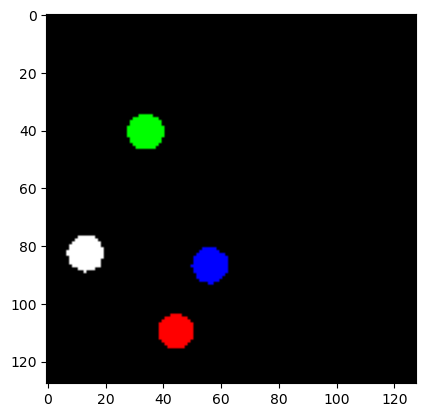

In [12]:
plt.imshow(image[0].permute(1,2,0).numpy())

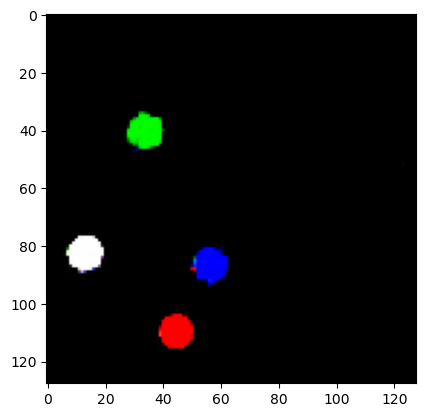

In [13]:
plt.imshow((recons_image.permute(1,2,0)*255).byte())

torch.Size([1024, 4, 4, 3])


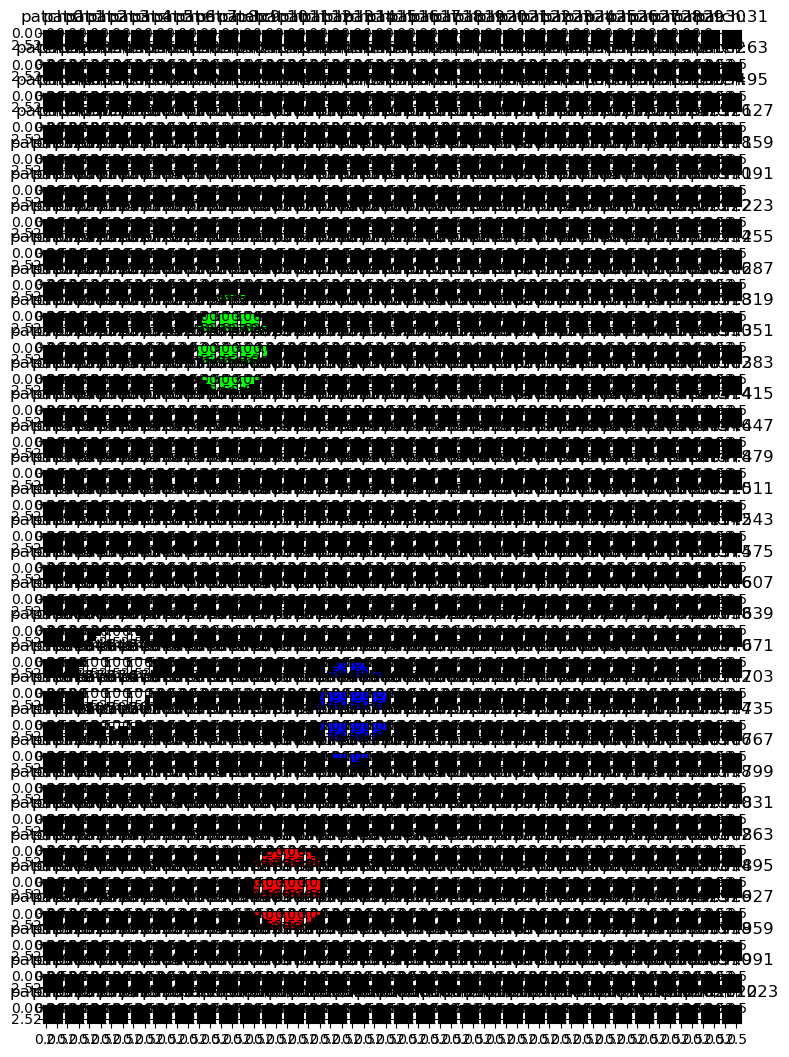

In [14]:
plot_image_patches(image[0], patch_size=(enc_dec.patch_size,enc_dec.patch_size), num_patches_sqrt=image[0].shape[2]//enc_dec.patch_size);

torch.Size([1024, 4, 4, 3])


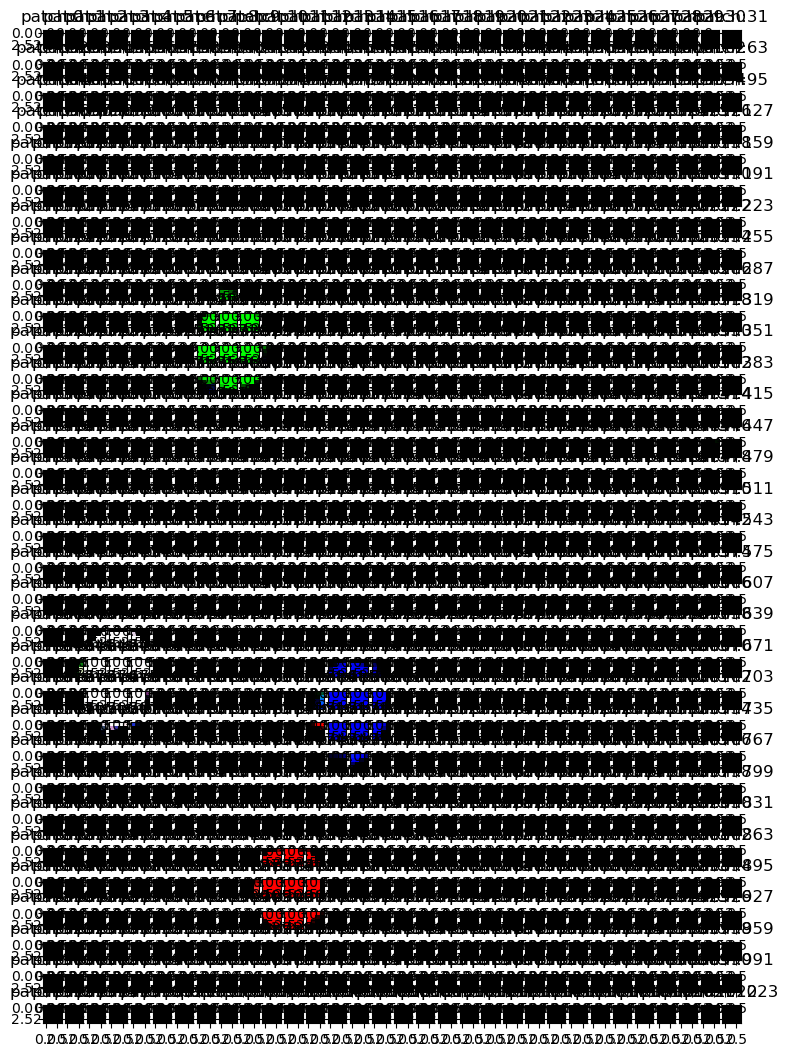

In [15]:
plot_image_patches(recons_image*255, patch_size=(enc_dec.patch_size,enc_dec.patch_size), num_patches_sqrt=image[0].shape[2]//enc_dec.patch_size);

In [16]:
from matplotlib import pyplot as plt
import numpy as np


def plot_traversal(model, patch, figure_width=10.5, row_slice=(0,5),num_cols=10, image_height=1.5):
    """
    Plot a traversal of the latent space.
    
    Steps are:
        1) encode an input to a latent representation
        2) adjust each latent value from -3 to 3 while keeping other values fixed
        3) decode each adjusted latent representation
        4) display
    """

    mu = model.get_encoding_for_dynamics(patch)
    z = mu  # since we're not training, no noise is added
    
    num_rows = row_slice[1] - row_slice[0]
    fig = plt.figure(figsize=(figure_width, image_height * num_rows))
    
    for i in range(*row_slice):
        row_iter_idx = i - row_slice[0]
        z_i_values = np.linspace(-1.0, 1.0, num_cols)
        z_i = z[0][i].detach().cpu().numpy()
        z_diffs = np.abs((z_i_values - z_i))
        j_min = np.argmin(z_diffs)
        for j in range(num_cols):
            z_i_value = z_i_values[j]
            if j != j_min:
                z[0][i] = z_i_value
            else:
                z[0][i] = float(z_i)
                
            x = model.decode(z).detach().cpu().numpy()
            
            ax = fig.add_subplot(num_rows, num_cols, row_iter_idx * num_cols + j + 1)
            ax.imshow((x[0]*255).astype(np.uint8).transpose(1,2,0))
            
            if row_iter_idx == 0 or j == j_min:
                ax.set_title(f'{z[0][i]:.1f}')
            
            if j == j_min:
                ax.set_xticks([], [])
                ax.set_yticks([], []) 
                color = 'mediumseagreen'
                width = 8
                for side in ['top', 'bottom', 'left', 'right']:
                    ax.spines[side].set_color(color)
                    ax.spines[side].set_linewidth(width)
            else:
                ax.axis('off')
        z[0][i] = float(z_i)
        
    plt.tight_layout()
    fig.subplots_adjust(wspace=0.04)


In [27]:
from src.patch_utils import image_to_patches

In [28]:
patches = image_to_patches(image[0], patch_size=(enc_dec.patch_size,enc_dec.patch_size), num_patches_sqrt=image[0].shape[2]//enc_dec.patch_size)



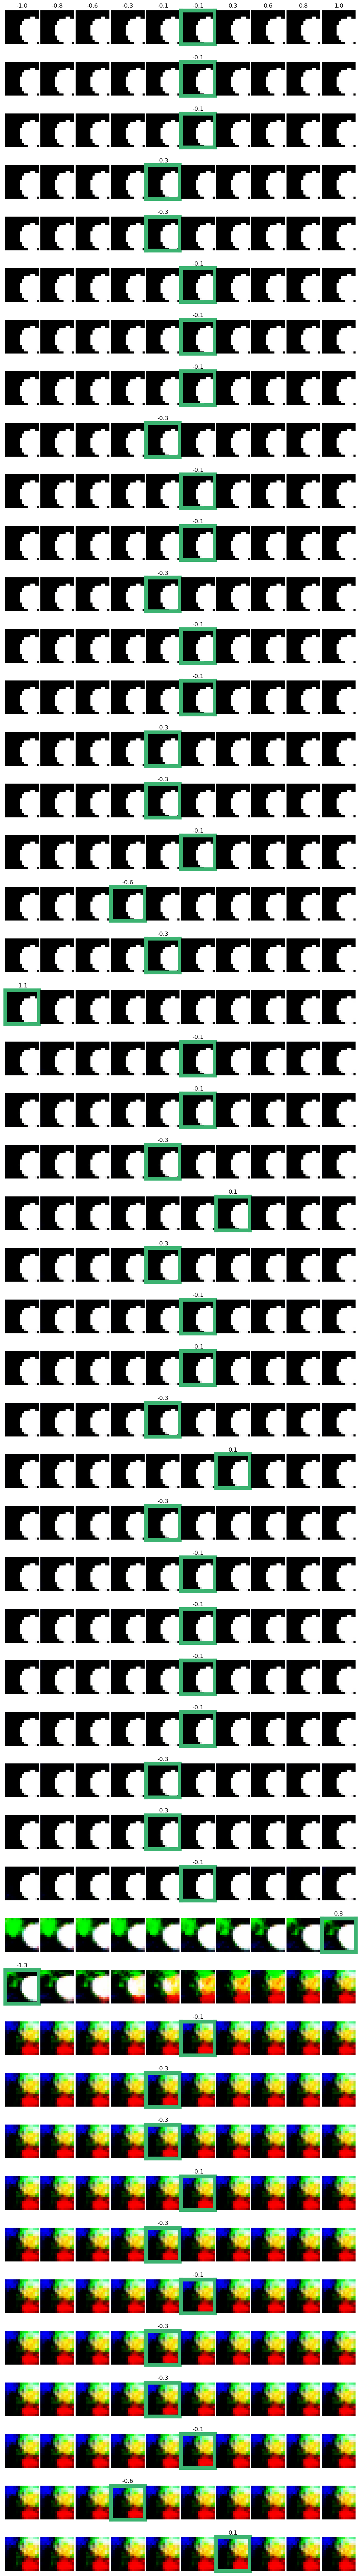

In [32]:
plot_traversal(enc_dec, patches[12].unsqueeze(0), row_slice=(0,50), num_cols=10)


In [5]:
from src.datasets import ImageTransitionDataset

In [6]:
data_path = "/cluster/scratch/gboeshertz/patch_rl/data/expert_visual_1000transitions_4_all_sprite_mover_True_4instantmoveno_targets.npz"
print(data_path)
dataset = ImageTransitionDataset(data_path=data_path)


/cluster/scratch/gboeshertz/patch_rl/data/expert_visual_1000transitions_4_all_sprite_mover_True_4instantmoveno_targets.npz


In [14]:
sum([d[-1] for d in dataset])

tensor(17)

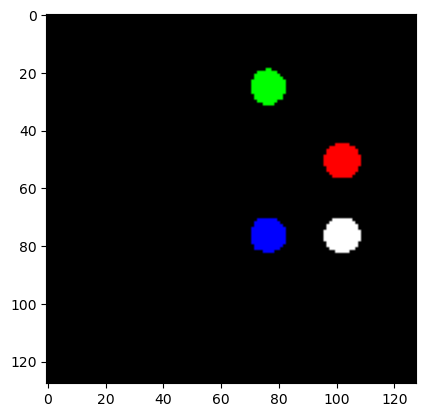

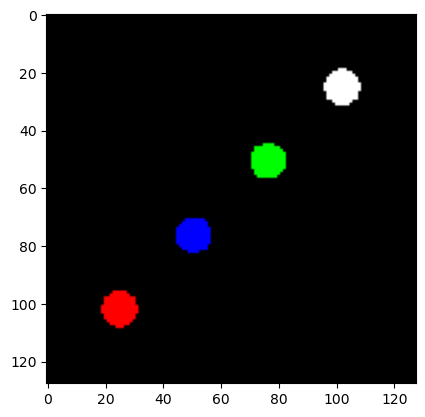

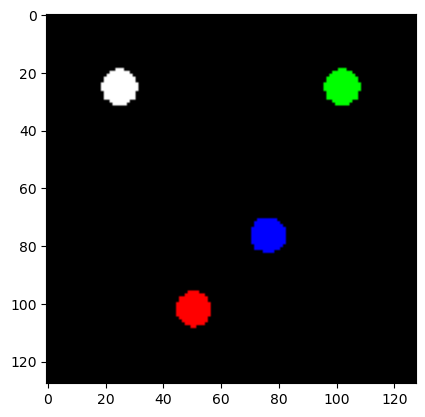

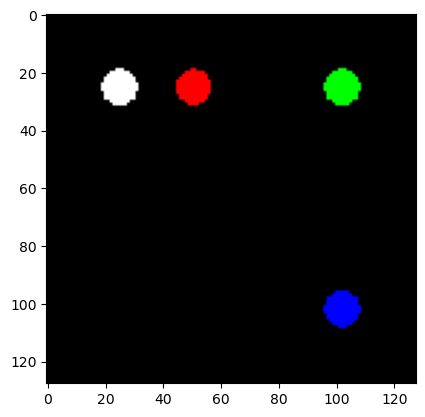

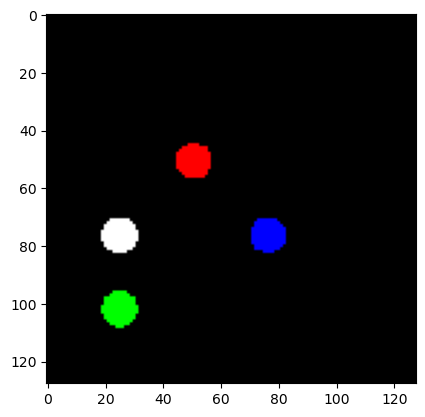

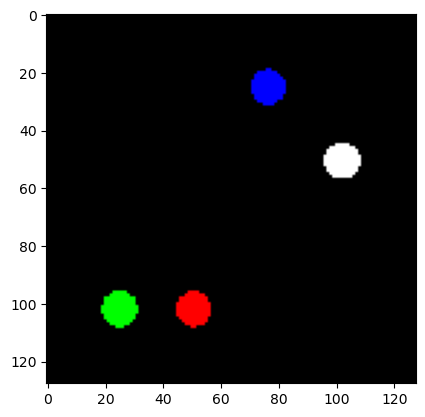

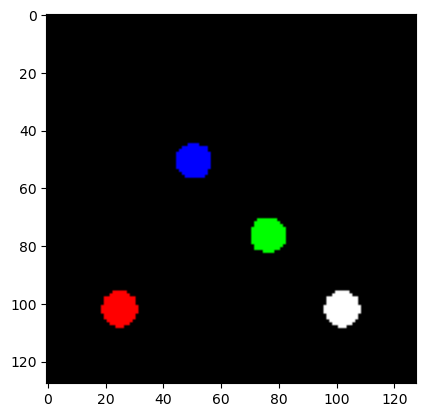

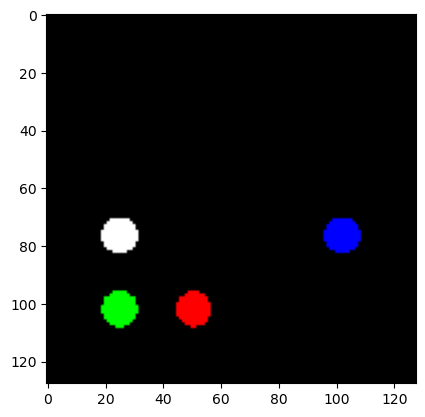

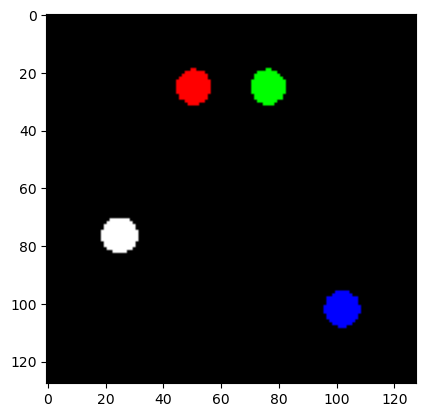

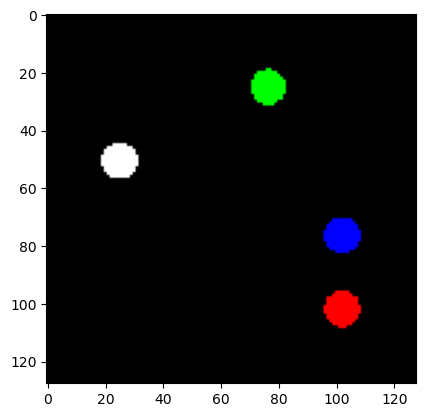

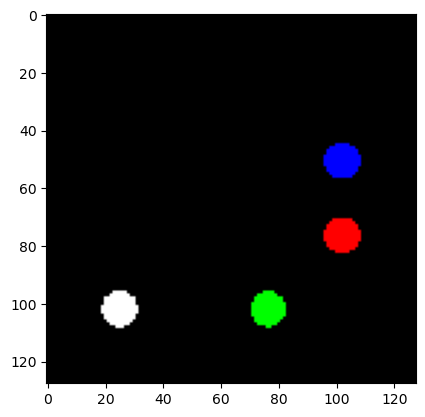

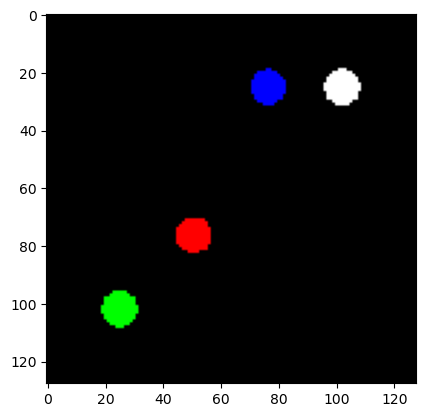

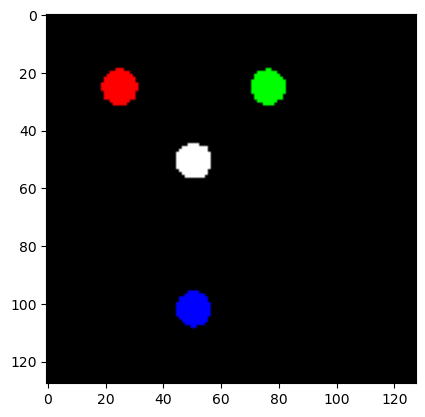

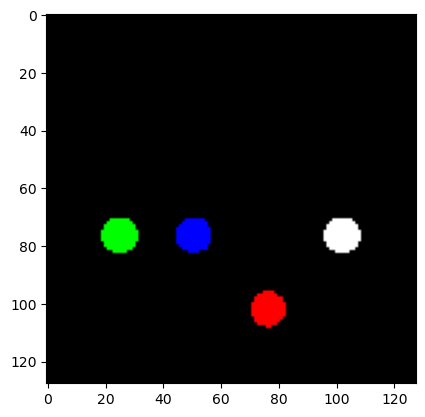

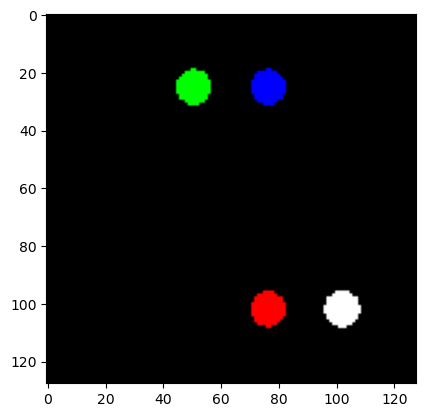

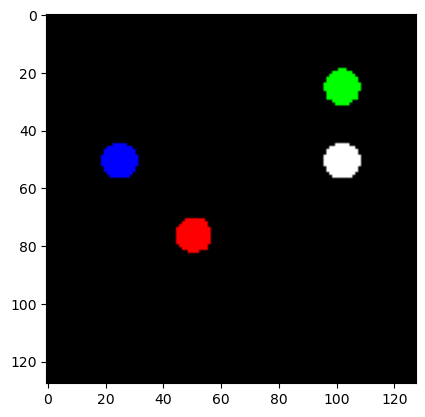

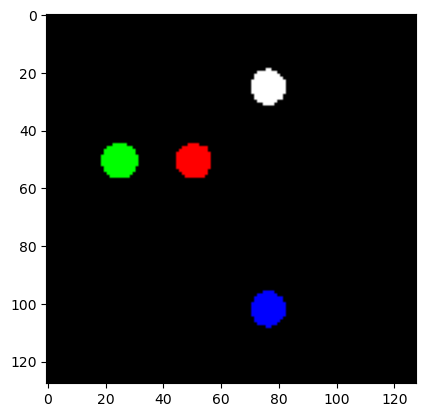

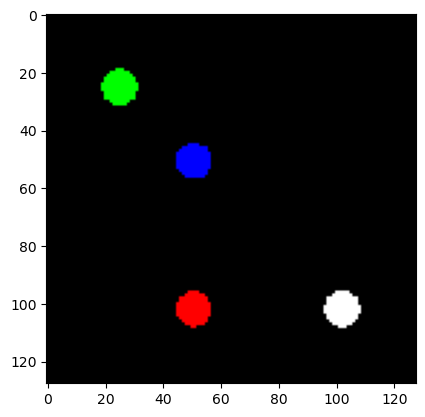

In [12]:
ep_end = True
for i in range(1000):
    img = dataset[i][0]
    if ep_end:
        plt.imshow(img.permute(1,2,0).numpy())
        plt.show()
        ep_end = False
    else:
        ep_end = dataset[i][-1]
